<font size="6"> **ML-Sentiment Factor in SEC 10-K Fillings** </font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

In [3]:
import nltk
import numpy as np
import pandas as pd
import scipy
import pickle
import datetime as dt

import os

from tqdm import tqdm

In [4]:
from src import utils
from src.load_data import load_sec10k, io_utils
from src.nlp_quant import bow_sent

In [5]:
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, mutual_info_classif

from sklearn import metrics

In [6]:
cfg = utils.read_conf()

In [7]:
INPATH1 = os.path.join(io_utils.interim_path, 'sec_fillings', '')
INPATH2 = os.path.join(io_utils.raw_path, 'market_data', cfg['quantopian']['dataset4']['folder'],'')
os.path.isdir(INPATH1), os.path.isdir(INPATH2)

(True, True)

In [8]:
INFILE1 = 'metadata.pkl'
INFILE2 = 'tenks_risk_tfidf_by_sent.pkl'
INFILE3 =  'parsed_sentiment_loughran_mcdonald.csv'
INFILE4 =  'tenks_risk_doc_len.csv'
INFILE5 = cfg['quantopian']['dataset4']['prices']
INFILE6 = cfg['output']['interim']['sector_factors']
INFILE7 = cfg['output']['interim']['pricing']

In [9]:
OUTPATH =  os.path.join(io_utils.processed_path, 'sec_fillings', '')
os.path.isdir(OUTPATH)

True

In [10]:
OUTFILE1 = 'sec_10k_mlbow_sent_alpha.csv'
FLG_OUTPUT = False  # Write predictions

In [11]:
example_ticker = 'amzn'

In [12]:
START_DT = '1998'
END_DT = '2018'
train_test_split_yr = '2016'
KFOLDS = 3
RND_SEED = 123

# Load Data

## Corpus Data

In [13]:
with open(INPATH1 + INFILE1, 'rb') as file:
    metadata = pickle.load(file)

In [14]:
tf_idf_by_sent = bow_sent.read_sent_tfidf_dict(path=INPATH1, name=INFILE2)

In [15]:
tf_idf_by_sent.keys()

dict_keys(['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting'])

In [16]:
tf_idf_by_sent['negative'].iloc[0:2,0:10]

abandon  abandonment  abandonments  abdicate  abdication  \
ticker date                                                                   
aal    2003-04-15      0.0          0.0           0.0       0.0         0.0   
       2004-02-27      0.0          0.0           0.0       0.0         0.0   

                   abdications  aberrant  aberration  aberrational  \
ticker date                                                          
aal    2003-04-15          0.0       0.0         0.0           0.0   
       2004-02-27          0.0       0.0         0.0           0.0   

                   aberrations  
ticker date                     
aal    2003-04-15          0.0  
       2004-02-27          0.0

In [17]:
tf_idf_by_sent['negative'].iloc[:5,0]  # underlying pandas is an sparse data structure

ticker  date      
aal     2003-04-15    0.0
        2004-02-27    0.0
        2005-02-25    0.0
        2006-02-24    0.0
        2007-02-23    0.0
Name: abandon, dtype: Sparse[float64, 0.0]

In [18]:
doc_lens = pd.read_csv(INPATH1 + INFILE4, parse_dates=['date'], index_col=[0,1])['doc_len']

## Sentiemnts Metadata

In [19]:
sentiment_df =  pd.read_csv(INPATH1 + INFILE3)

## Prices

In [20]:
# Yearly pricing
pricing_yr = pd.read_csv(INPATH2 + INFILE5, parse_dates=['date'])
pricing_yr = pricing_yr.pivot(index='date', columns='ticker', values='adj_close')
pricing_yr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 1962-01-01 to 2018-01-01
Columns: 11941 entries, A to ZZZ
dtypes: float64(11941)
memory usage: 5.2 MB


In [21]:
pd.concat([pricing_yr.head(2), pricing_yr.tail(2)], axis=0)

ticker,A,AA,AAAP,AABA,AAC,AADR,AAIT,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,AAPC,AAPL,AAT,AAU,AAV,AAVL,AAWW,AAXJ,AAXN,AA_P_B,AA_W,...,ZOES,ZOM,ZOOM,ZPIN,ZQK,ZROZ,ZS,ZSAN,ZSL,ZSML,ZSPH,ZTO,ZTR,ZTS,ZU,ZUMZ,ZUO,ZVZZC,ZVZZCNX,ZX,ZXYZ_A,ZYME,ZYNE,ZZK,ZZZ
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1962-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,66.653918,53.87,81.62,69.85,9.00,58.835707,NaN,51.803585,81.6,3.378882,39.797356,37.82,36.522919,99.593649,10.6,167.90118,37.654925,1.03,4.3,NaN,58.65,75.858764,26.50,NaN,NaN,...,16.72,1.9771,NaN,18.2,NaN,120.593382,NaN,10.40,31.40,26.9,NaN,15.641173,12.643875,71.815333,NaN,20.825,NaN,100.1,NaN,1.2165,NaN,7.5931,12.52,25.0,0.01
2018-01-01,61.800000,46.88,81.63,73.35,9.81,52.880000,NaN,37.990000,67.9,2.575000,43.740000,46.00,35.250000,135.860000,NaN,185.40000,38.860000,0.71,3.1,NaN,71.45,70.250000,64.98,NaN,NaN,...,10.16,2.2100,NaN,NaN,NaN,115.750000,36.67,4.68,34.91,NaN,NaN,19.450000,11.450000,86.150000,NaN,24.300,26.74,NaN,NaN,1.3800,NaN,15.3400,9.17,NaN,NaN


In [22]:
# Daily pricing
pricing = pd.read_csv(io_utils.interim_path + INFILE7, parse_dates=['date'], index_col='date')
pricing.index = pricing.index.tz_convert(tz=None)

pd.concat([pricing.head(2), pricing.tail(2)], axis=0)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,...,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-06,57.014,10.822,59.209,42.399,NaN,31.088,19.926,41.270,32.27,30.936,26.230,34.990,70.301,41.26,20.703,26.659,10.986,29.308,23.236,50.648,46.749,20.247,32.972,22.599,48.45,...,35.023,28.571,22.424,26.328,73.779,28.636,14.060,44.446,NaN,15.490,15.583,25.603,85.930,85.815,17.834,19.045,25.095,59.697,33.386,25.945,NaN,30.184,49.601,23.427,NaN
2011-01-07,57.495,10.976,60.790,42.702,NaN,31.150,20.009,41.338,32.04,30.756,26.445,35.070,70.026,40.76,20.703,26.555,10.986,29.371,23.145,51.440,47.314,20.088,32.596,22.458,48.69,...,34.814,28.589,22.594,25.796,73.468,28.479,14.283,44.545,NaN,15.346,16.011,25.509,88.972,87.296,17.993,19.010,24.954,60.023,33.251,25.583,NaN,30.560,49.592,23.182,NaN
2016-01-04,130.838,39.933,151.537,100.621,52.526,97.613,40.544,96.984,91.97,51.310,33.183,77.587,267.230,60.31,39.633,53.390,8.493,106.357,27.897,300.779,57.212,36.450,74.077,37.451,52.31,...,79.032,56.158,47.153,49.176,139.143,49.421,22.642,57.521,37.972,16.153,27.113,66.912,65.687,89.186,32.915,36.226,43.194,70.617,58.018,26.056,34.923,49.300,99.714,25.983,46.398
2016-01-05,131.369,39.552,150.502,98.100,52.307,99.041,40.534,97.489,92.34,50.933,33.553,77.776,269.531,60.39,40.103,53.829,8.611,107.837,27.859,302.012,57.410,37.378,75.313,37.553,52.02,...,76.958,55.916,47.659,49.157,136.146,49.610,22.720,58.887,37.947,16.089,27.177,67.441,66.929,89.761,33.247,36.302,43.836,71.218,59.201,26.005,34.913,49.177,101.790,25.701,47.124


## Sector Metadata 

In [23]:
SECTOR_FOLDER = cfg['quantopian']['dataset1']['sector_folder']
SECTOR_NAMES = cfg['quantopian']['dataset1']['sector_names']

# Specify the bundle path
sector_file = os.path.join(io_utils.raw_path, 'market_data',SECTOR_FOLDER, SECTOR_NAMES)

In [24]:
sector_names = pd.read_csv(sector_file, usecols=['Sector', 'sector_id'], index_col='sector_id')
sector_names.loc[-1, 'Sector'] = 'No sector'
sector_names = sector_names.drop_duplicates()

sector_names

,Sector
sector_id,
0,Healthcare
1,Technology
2,Consumer Defensive
3,Industrials
4,Utilities
5,Financial Services
6,Real Estate
7,Communication Services
8,Consumer Cyclical


In [25]:
sector_factor_df = pd.read_csv(io_utils.interim_path + INFILE6, parse_dates=['date'], index_col=[0,1])

sector_factor_df = sector_factor_df.reset_index().merge(sector_names, how='left', left_on='sector_code', right_index=True).\
    set_index(keys=['date', 'asset'])[['sector_code', 'Sector']]
sector_factor_df.columns = ['sector_code', 'sector']

pd.concat([sector_factor_df.head(2), sector_factor_df.tail(2)], axis=0)

sector_code              sector
date                      asset                                 
2013-01-03 00:00:00+00:00 A                0          Healthcare
                          AAL              3         Industrials
2015-12-28 00:00:00+00:00 ZION             5  Financial Services
                          ZTS              0          Healthcare

In [26]:
# Mapping from asset to sector (no date)
sector_to_asset = sector_factor_df.reset_index('asset').drop_duplicates().set_index('asset')
sector_to_asset.index = pd.Index([x.lower() for x in sector_to_asset.index], name='ticker')

pd.concat([sector_to_asset.head(2), sector_to_asset.tail(2)], axis=0)

,sector_code,sector
ticker,,
a,0,Healthcare
aal,3,Industrials
hpe,1,Technology
csra,1,Technology


# Data Preparation

## Compute TF-IDF matrix based on Loughran Mcdonald textual analysis in financial data

In [27]:
sentiments = sentiment_df.columns.tolist()[:-1]
sentiments

['negative',
 'positive',
 'uncertainty',
 'litigious',
 'constraining',
 'interesting']

In [28]:
sentiment_df.shape # complete vocab size

(2719, 7)

In [29]:
word_vocab = pd.Series(index=sentiment_df['word'].values, data=sentiment_df.sum(axis=1).values )
word_vocab[word_vocab>1]  # tokens that appear in more than one sentiment

abrogate       2
abrogation     2
abrogations    2
acquit         2
acquittal      2
              ..
violative      2
void           2
volatile       2
volatility     2
willfully      2
Length: 144, dtype: int64

In [30]:
tfidf = bow_sent.get_combined_tfidf(tf_idf_by_sent)
tfidf['date_filling'] = tfidf.index.get_level_values('date')
tfidf.index = pd.MultiIndex.from_tuples([(ticker, dt.date(year=date.year, month=1, day=1)) for ticker, date in tfidf.index], names=tfidf.index.names )

pd.concat([tfidf.head(2), tfidf.tail(2)], axis=0)

Number of removed words:
uncertainty: 32
litigious: 95
constraining: 18
interesting: 2


abandon  abandonment  abandonments  abdicate  abdication  \
ticker date                                                                    
aal    2003-01-01  0.000000     0.000000           0.0       0.0         0.0   
       2004-01-01  0.000000     0.000000           0.0       0.0         0.0   
zts    2019-01-01  0.012278     0.013347           0.0       0.0         0.0   
       2020-01-01  0.013254     0.014408           0.0       0.0         0.0   

                   abdications  aberrant  aberration  aberrational  \
ticker date                                                          
aal    2003-01-01          0.0       0.0         0.0           0.0   
       2004-01-01          0.0       0.0         0.0           0.0   
zts    2019-01-01          0.0       0.0         0.0           0.0   
       2020-01-01          0.0       0.0         0.0           0.0   

                   aberrations  abet  abnormal  abnormalities  abnormality  \
ticker date                                                                  
aal    2003-01-01          0.0   0.0       0.0            0.0          0.0   
       2004-01-01          0.0   0.0       0.0            0.0          0.0   
zts    2019-01-01          0.0   0.0       0.0            0.0          0.0   
       2020-01-01          0.0   0.0       0.0            0.0          0.0   

                   abnormally  abolish  abrogate  abrogation  abrogations  \
ticker date                                                                 
aal    2003-01-01         0.0      0.0       0.0         0.0          0.0   
       2004-01-01         0.0      0.0       0.0         0.0          0.0   
zts    2019-01-01         0.0      0.0       0.0         0.0          0.0   
       2020-01-01         0.0      0.0       0.0         0.0          0.0   

                   abrupt  abruptly  abruptness   absence  absences  \
ticker date                                                           
aal    2003-01-01     0.0       0.0         0.0  0.033477       0.0   
       2004-01-01     0.0       0.0         0.0  0.000000       0.0   
zts    2019-01-01     0.0       0.0         0.0  0.000000       0.0   
       2020-01-01     0.0       0.0         0.0  0.000000       0.0   

                   absenteeism  ...     march  mighty  mortgagee  oink  \
ticker date                     ...                                      
aal    2003-01-01          0.0  ...  0.315236     0.0        0.0   0.0   
       2004-01-01          0.0  ...  0.385279     0.0        0.0   0.0   
zts    2019-01-01          0.0  ...  0.173299     0.0        0.0   0.0   
       2020-01-01          0.0  ...  0.184606     0.0        0.0   0.0   

                   piracy  rabbi  reductions   relieve  remedial  repossess  \
ticker date                                                                   
aal    2003-01-01     0.0    0.0    0.183164  0.000000  0.097192        0.0   
       2004-01-01     0.0    0.0    0.264436  0.000000  0.000000        0.0   
zts    2019-01-01     0.0    0.0    0.017230  0.000000  0.000000        0.0   
       2020-01-01     0.0    0.0    0.021107  0.028421  0.000000        0.0   

                   secret  seizures  soar  sputter  sublessee  sublessees  \
ticker date                                                                 
aal    2003-01-01     0.0       0.0   0.0      0.0        0.0         0.0   
       2004-01-01     0.0       0.0   0.0      0.0        0.0         0.0   
zts    2019-01-01     0.0       0.0   0.0      0.0        0.0         0.0   
       2020-01-01     0.0       0.0   0.0      0.0        0.0         0.0   

                   sublessor  suspenders  sustainability  touche  toxic  \
ticker date                                                               
aal    2003-01-01        0.0         0.0             0.0     0.0    0.0   
       2004-01-01        0.0         0.0             0.0     0.0    0.0   
zts    2019-01-01        0.0         0.0             0.0     0.0    0.0   
 

In [31]:
tfidf.shape

(8637, 2720)

## Targets

In [32]:
def compute_fwd_targets(prices, tau, name, index_name='ticker'):
    prices_cp = prices.copy()
    prices_cp.columns = [x.lower() for x in prices_cp.columns]
    targets = ( (prices_cp.shift(-tau).subtract(prices_cp)).div(prices_cp) ).stack()
    targets.name = name
    targets.index.rename(inplace=True, level=1, names=index_name)
    
    return targets

### Long Term Target

In [33]:
pricing_yr.columns = [x.lower() for x in pricing_yr.columns]
targets_yr = compute_fwd_targets(pricing_yr, tau=1, name='1yr_fwd_rets').loc[pd.Timestamp(START_DT):]

targets_yr.sample(5)

date        ticker
2006-01-01  afl       0.382414
2014-01-01  ziv      -0.011013
2012-01-01  ccz       0.001361
2017-01-01  ni        0.061443
2001-01-01  slg       0.085998
Name: 1yr_fwd_rets, dtype: float64

In [34]:
aapl_prices = pricing_yr.loc['2017':'2018', 'aapl']
aapl_prices

date
2017-01-01    167.90118
2018-01-01    185.40000
Name: aapl, dtype: float64

In [35]:
aapl_ret_2017 = (aapl_prices.iloc[-1] - aapl_prices.iloc[0]) / aapl_prices.iloc[0]
aapl_ret_2017

0.10422094647492033

In [36]:
np.isclose(aapl_ret_2017, (pricing_yr.loc['2018', 'aapl'].values - pricing_yr.loc['2017', 'aapl'].values) / pricing_yr.loc['2017', 'aapl'].values)

array([ True])

In [37]:
np.isclose(aapl_ret_2017, targets_yr.loc[pd.Timestamp('2017'), 'aapl'])

True

In [38]:
pricing_yr.pct_change(-1).loc['2017', 'aapl']

date
2017-01-01   -0.094384
Name: aapl, dtype: float64

### Short term targets

In [39]:
targets_st = compute_fwd_targets(pricing, tau=5, name='5d_fwd_rets').to_frame()
targets_st['20d_fwd_rets'] = compute_fwd_targets(pricing, tau=5, name='20d_fwd_rets')

targets_st.sample(4)

,,5d_fwd_rets,20d_fwd_rets
date,ticker,,
2015-07-28,nwsa,-0.015502,-0.015502
2013-04-03,var,0.004204,0.004204
2013-10-17,cbs,0.019852,0.019852
2013-04-09,m,-0.011882,-0.011882


In [40]:
join_cols = ['date', 'ticker']
tfidf_targets = tfidf.merge(targets_yr, how='inner', on=join_cols).sort_index()

pd.concat([tfidf_targets.head(2), tfidf_targets.tail(2)], axis=0)

abandon  abandonment  abandonments  abdicate  abdication  \
date       ticker                                                              
1998-01-01 abt     0.000000     0.000000           0.0       0.0         0.0   
           adbe    0.000000     0.000000           0.0       0.0         0.0   
2017-01-01 zion    0.000000     0.000000           0.0       0.0         0.0   
           zts     0.010714     0.011646           0.0       0.0         0.0   

                   abdications  aberrant  aberration  aberrational  \
date       ticker                                                    
1998-01-01 abt             0.0       0.0         0.0           0.0   
           adbe            0.0       0.0         0.0           0.0   
2017-01-01 zion            0.0       0.0         0.0           0.0   
           zts             0.0       0.0         0.0           0.0   

                   aberrations  abet  abnormal  abnormalities  abnormality  \
date       ticker                                                            
1998-01-01 abt             0.0   0.0       0.0            0.0          0.0   
           adbe            0.0   0.0       0.0            0.0          0.0   
2017-01-01 zion            0.0   0.0       0.0            0.0          0.0   
           zts             0.0   0.0       0.0            0.0          0.0   

                   abnormally  abolish  abrogate  abrogation  abrogations  \
date       ticker                                                           
1998-01-01 abt            0.0      0.0       0.0         0.0          0.0   
           adbe           0.0      0.0       0.0         0.0          0.0   
2017-01-01 zion           0.0      0.0       0.0         0.0          0.0   
           zts            0.0      0.0       0.0         0.0          0.0   

                   abrupt  abruptly  abruptness   absence  absences  \
date       ticker                                                     
1998-01-01 abt        0.0       0.0         0.0  0.000000       0.0   
           adbe       0.0       0.0         0.0  0.000000       0.0   
2017-01-01 zion       0.0       0.0         0.0  0.018155       0.0   
           zts        0.0       0.0         0.0  0.000000       0.0   

                   absenteeism  ...  mighty  mortgagee  oink  piracy  \
date       ticker               ...                                    
1998-01-01 abt             0.0  ...     0.0        0.0   0.0     0.0   
           adbe            0.0  ...     0.0        0.0   0.0     0.0   
2017-01-01 zion            0.0  ...     0.0        0.0   0.0     0.0   
           zts             0.0  ...     0.0        0.0   0.0     0.0   

                      rabbi  reductions  relieve  remedial  repossess  secret  \
date       ticker                                                               
1998-01-01 abt     0.000000    0.000000      0.0       0.0        0.0     0.0   
           adbe    0.000000    0.034246      0.0       0.0        0.0     0.0   
2017-01-01 zion    0.012734    0.027760      0.0       0.0        0.0     0.0   
           zts     0.000000    0.048960      0.0       0.0        0.0     0.0   

                   seizures  soar  sputter  sublessee  sublessees  sublessor  \
date       ticker                                                              
1998-01-01 abt          0.0   0.0      0.0        0.0         0.0        0.0   
           adbe         0.0   0.0      0.0        0.0         0.0        0.0   
2017-01-01 zion         0.0   0.0      0.0        0.0         0.0        0.0   
           zts          0.0   0.0      0.0        0.0         0.0        0.0   

                   suspenders  sustainability  touche  toxic  trauma  tumor  \
date       ticker                                                             
1998-01-01 abt            0.0             0.0     0.0    0.0     0.0    0.0   
           adbe           0.0             0.0     0.0    0.0     0.0    0.0   
2017-01-01 zion           0.0             

In [41]:
date_filling = tfidf_targets.pop('date_filling')

In [42]:
tfidf_targets_st = tfidf.merge(targets_st, how='inner', left_on=['date_filling', 'ticker'],
                               right_on=['date', 'ticker']).\
    reset_index().set_index(['date_filling', 'ticker']).sort_index()

pd.concat([tfidf_targets_st.head(2), tfidf_targets_st.tail(2)], axis=0)

,,abandon,abandonment,abandonments,abdicate,abdication,abdications,aberrant,aberration,aberrational,aberrations,abet,abnormal,abnormalities,abnormality,abnormally,abolish,abrogate,abrogation,abrogations,abrupt,abruptly,abruptness,absence,absences,absenteeism,...,mighty,mortgagee,oink,piracy,rabbi,reductions,relieve,remedial,repossess,secret,seizures,soar,sputter,sublessee,sublessees,sublessor,suspenders,sustainability,touche,toxic,trauma,tumor,vacant,5d_fwd_rets,20d_fwd_rets
date_filling,ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-26,dfs,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.007056,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.004121,0.000000,0.0,0.0,0.0,-0.006757,-0.006757
2011-01-27,adbe,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.083377,0.0,0.077702,0.000000,0.000000,0.0,0.036582,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,-0.009453,-0.009453
2015-12-18,de,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00987,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.035581,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.02826,0.047567,0.000000,0.0,0.0,0.0,0.040015,0.040015
2015-12-21,a,0.037755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.076734,0.000000,0.013783,0.0,0.000000,0.015569,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.080921,0.0,0.0,0.0,0.045782,0.045782


## Train/ Test Split

### Long-Term Targets

In [43]:
idx_train = list(set([(date, ticker) for date, ticker in tfidf_targets.index if date < pd.Timestamp(train_test_split_yr)]))
idx_test = list(set([(date, ticker) for date, ticker in tfidf_targets.index if date >= pd.Timestamp(train_test_split_yr)]))

In [44]:
splits = pd.Series(index=idx_train + idx_test, data= ['train']*len(idx_train) + ['test']*len(idx_test))
splits.sample(2)

(2007-01-01 00:00:00, syk)    train
(2012-01-01 00:00:00, var)    train
dtype: object

In [45]:
X_train = tfidf_targets.loc[idx_train].drop(columns=['1yr_fwd_rets']).copy()
X_test = tfidf_targets.loc[idx_test].drop(columns=['1yr_fwd_rets']).copy()

In [46]:
print(X_train.shape, X_test.shape)

(6361, 2719) (893, 2719)


In [47]:
y_train = tfidf_targets.loc[idx_train, '1yr_fwd_rets'].copy()
y_test = tfidf_targets.loc[idx_test, '1yr_fwd_rets'].copy()

In [48]:
y_train_c = pd.qcut(y_train, 5, labels=False) - 2
y_test_c = pd.qcut(y_test, 5, labels=False) - 2
y_train_c.describe()

count    6361.000000
mean       -0.000314
std         1.414436
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: 1yr_fwd_rets, dtype: float64

In [49]:
y_train_c = (y_train>=0).astype(int)
y_test_c = (y_test>=0).astype(int)
y_train_c.describe()

count    6361.000000
mean        0.703349
std         0.456817
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: 1yr_fwd_rets, dtype: float64

In [50]:
print(y_train.shape, y_test.shape)

(6361,) (893,)


### Short-Term Targets

In [51]:
train_test_split_yr_st = '2014'

In [52]:
idx_train_st = list(set([(date, ticker) for date, ticker in tfidf_targets_st.index if date < pd.Timestamp(train_test_split_yr_st)]))
idx_test_st = list(set([(date, ticker) for date, ticker in tfidf_targets_st.index if date >= pd.Timestamp(train_test_split_yr_st)]))

In [53]:
splits_st = pd.Series(index=idx_train_st + idx_test_st, data=['train']*len(idx_train_st) + ['test']*len(idx_test_st))
splits_st.sample(2)

(2015-02-13 00:00:00, ma)      test
(2013-02-20 00:00:00, aiz)    train
dtype: object

In [54]:
targets_cols_st = ['5d_fwd_rets' ,'20d_fwd_rets']
X_train_st = tfidf_targets_st.loc[idx_train_st].drop(columns=targets_cols_st).copy()
X_test_st = tfidf_targets_st.loc[idx_test_st].drop(columns=targets_cols_st).copy()

In [55]:
print(X_train_st.shape, X_test_st.shape)

(1265, 2719) (877, 2719)


In [56]:
y_train_5d = tfidf_targets_st.loc[idx_train_st, '5d_fwd_rets'].copy()
y_test_5d = tfidf_targets_st.loc[idx_test_st, '5d_fwd_rets'].copy()

y_train_20d = tfidf_targets_st.loc[idx_train_st, '20d_fwd_rets'].copy()
y_test_20d = tfidf_targets_st.loc[idx_test_st, '20d_fwd_rets'].copy()

### Target: Classification

In [57]:
y_train_c = pd.qcut(y_train, 5, labels=False) - 2
y_test_c = pd.qcut(y_test, 5, labels=False) - 2
y_train_c.describe()

count    6361.000000
mean       -0.000314
std         1.414436
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: 1yr_fwd_rets, dtype: float64

In [58]:
y_train_c = (y_train>=0).astype(int)
y_test_c = (y_test>=0).astype(int)
y_train_c.describe()

count    6361.000000
mean        0.703349
std         0.456817
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: 1yr_fwd_rets, dtype: float64

In [59]:
print(y_train.shape, y_test.shape)

(6361,) (893,)


In [60]:
y_train_5d_bin = (y_train_5d>=0).astype(int)
y_test_5d_bin = (y_test_5d>=0).astype(int)

y_train_20d_bin = (y_train_20d>=0).astype(int)
y_test_20d_bin = (y_test_20d>=0).astype(int)

# Model Build

In [61]:
#selection = SelectPercentile(mutual_info_classif)

## Target: 1yr

In [62]:
logreg_l1 = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='liblinear', penalty='l1', C=100, max_iter=100).fit(X_train, y_train_c)
# smaller C stronger reg

In [63]:
logreg_l2 = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='lbfgs', penalty='l2', C=100, max_iter=1000).fit(X_train, y_train_c)

In [70]:
# Create the parameter dictionary
c_grid = [10.0**x for x in range(-2,3)]
alpha_grid = [10.0**x for x in range(-2,2)]
#featselectk_grid = [25, 50, 100]

# Instanciate Models
nbc = MultinomialNB()
logreg_l1 = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='liblinear', penalty='l1', max_iter=250)
logreg_l2 = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='lbfgs', penalty='l2', max_iter=1000)

# Create parameter dictionar for every estimator
params1 = {}
#params1['featselector__percentile'] = featselectk_grid
params1['classifier__alpha'] =  alpha_grid
params1['classifier'] = [nbc]

params2 = {}
#params2['featselector__percentile'] = featselectk_grid
params2['classifier__C'] =  c_grid
params2['classifier'] = [logreg_l1]

params3 = {}
#params3['featselector__percentile'] = featselectk_grid
params3['classifier__C'] = c_grid
params3['classifier'] = [logreg_l2]

# create a list of parameter dictionaries
params = [params1, params2, params3]

In [71]:
# create the Pipeline
pipe = Pipeline(
    [#('featselector', selection),
    ('classifier', nbc)]
)

# Fit hyperparameter CV grid search 
grid_cv = GridSearchCV(pipe, params, scoring=['accuracy', 'roc_auc'],
                    n_jobs=-1, refit='roc_auc',
                    cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_c))
grid_cv_res = grid_cv.fit(X_train, y_train_c)

## Champion Model Selection

In [72]:
def get_cv_summary(grid_cv_res):
    hparams = pd.DataFrame(grid_cv_res.cv_results_['params'])
    metrics = results_df = pd.DataFrame(grid_cv_res.cv_results_).filter(regex='(auc|mean_test_accuracy)')
    metrics['idx'] = metrics.index
    models = {nbc: 'nb', logreg_l1: 'logreg_l1', logreg_l2: 'logreg_l2' }
    hparams['classifier'] = hparams['classifier'].replace(models)
    hparams['classifier_params'] = hparams['classifier__alpha'].combine_first(hparams['classifier__C'])
    
    return pd.concat([hparams, metrics], axis=1)

In [73]:
grid_cv_sum = get_cv_summary(grid_cv_res)
grid_cv_sum

,classifier,classifier__alpha,classifier__C,classifier_params,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,idx
0,nb,0.01,NaN,0.01,0.694130,0.536038,0.540667,0.556962,0.544556,0.008974,8,0
1,nb,0.10,NaN,0.10,0.694130,0.535952,0.540418,0.566809,0.547726,0.013616,7,1
2,nb,1.00,NaN,1.00,0.695178,0.534383,0.545943,0.569055,0.549794,0.014414,4,2
3,nb,10.00,NaN,10.00,0.695807,0.503011,0.531187,0.540602,0.524933,0.015971,11,3
4,logreg_l1,NaN,0.01,0.01,0.680713,0.497641,0.494595,0.526445,0.506227,0.014350,14,4
5,logreg_l1,NaN,0.10,0.10,0.695807,0.495706,0.524286,0.551527,0.523840,0.022791,12,5
6,logreg_l1,NaN,1.00,1.00,0.698532,0.543162,0.585216,0.590697,0.573025,0.021235,1,6
7,logreg_l1,NaN,10.00,10.00,0.640881,0.529649,0.545958,0.569582,0.548396,0.016394,6,7
8,logreg_l1,NaN,100.00,100.00,0.591405,0.517285,0.513838,0.528980,0.520034,0.006480,13,8
9,logreg_l2,NaN,0.01,0.01,0.695807,0.505724,0.524945,0.550987,0.527219,0.018548,10,9


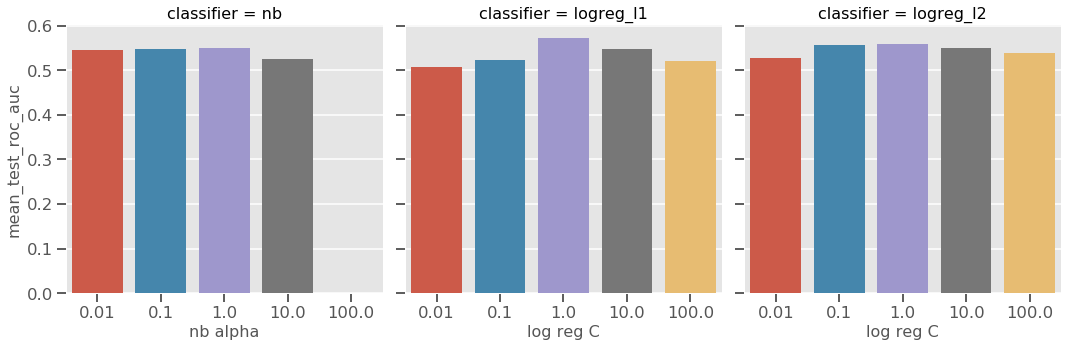

In [74]:
g = sns.catplot(x="classifier_params", col="classifier", y='mean_test_roc_auc', kind='bar', data=grid_cv_sum)
axs = g.axes
axs[0,0].set_xlabel('nb alpha')
axs[0,1].set_xlabel('log reg C')
axs[0,2].set_xlabel('log reg C')
plt.show()

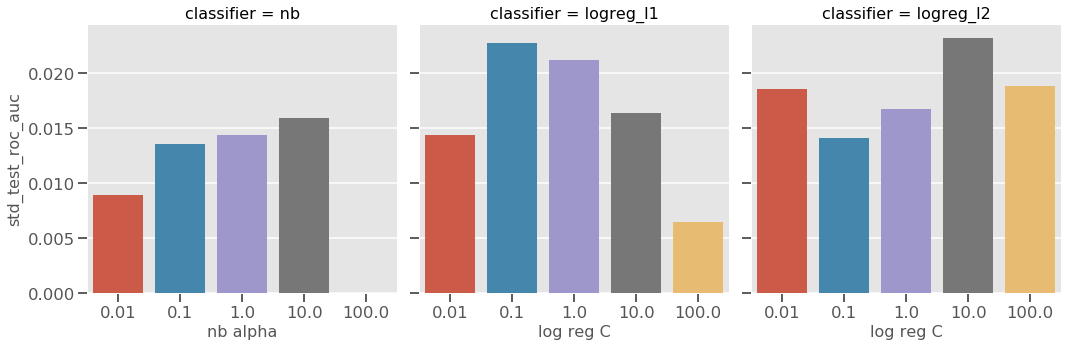

In [75]:
g = sns.catplot(x="classifier_params", col="classifier", y='std_test_roc_auc', kind='bar', data=grid_cv_sum)
axs = g.axes
axs[0,0].set_xlabel('nb alpha')
axs[0,1].set_xlabel('log reg C')
axs[0,2].set_xlabel('log reg C')
plt.show()

In [136]:
log_reg_l1_C = 100
model_mask = (grid_cv_sum['classifier']=='logreg_l1') & (grid_cv_sum['classifier__C']==log_reg_l1_C)

best_logreg_l1 = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='liblinear', penalty='l1', C=log_reg_l1_C, max_iter=500).fit(X_train, y_train_c)
best_logreg_l1_mean_cv_auc = grid_cv_sum.loc[model_mask, 'mean_test_roc_auc'].iloc[0]

In [126]:
log_reg_l2_C = 0.1
model_mask = (grid_cv_sum['classifier']=='logreg_l2') & (grid_cv_sum['classifier__C']==log_reg_l2_C)

best_logreg_l2 = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='lbfgs', penalty='l2', C=log_reg_l2_C, max_iter=1000, n_jobs=-1).fit(X_train, y_train_c)
best_logreg_l2_mean_cv_auc = grid_cv_sum.loc[model_mask, 'mean_test_roc_auc'].iloc[0]

In [127]:
nbc_alpha = 1
model_mask = (grid_cv_sum['classifier']=='nb') & (grid_cv_sum['classifier__alpha']==nbc_alpha)

best_nbc = MultinomialNB(alpha=nbc_alpha).fit(X_train, y_train_c)
best_nbc_mean_cv_auc = grid_cv_sum.loc[model_mask, 'mean_test_roc_auc'].iloc[0]

In [128]:
# Select champion model: Select a high AUC model, that has the lowest std dev in CV-evaluation score. This is log-reg-l1 at C=100, which may not be a highly regularized model but beeing |L1| reg many words in vocabulary are
champ_mod = best_logreg_l1
champ_mod_mean_cv_auc = best_logreg_l1_mean_cv_auc

In [139]:
auc_plot_data = [(best_logreg_l1, '(champ) ' + f'best log-reg-l1 C={log_reg_l1_C:0.2f})', best_logreg_l1_mean_cv_auc ),
                 (best_logreg_l2, f'best log-reg-l2: C={log_reg_l2_C:0.2f}', best_logreg_l2_mean_cv_auc),
                 (best_nbc, fr'best naive-bayes: $\alpha={nbc_alpha:0.2f}$', best_nbc_mean_cv_auc),
                 (grid_cv_res.best_estimator_, 'highest score model', grid_cv_res.best_score_)]

mean_cv_auc_lst = [best_logreg_l2_mean_cv_auc, best_logreg_l1_mean_cv_auc, best_nbc_mean_cv_auc, grid_cv_res.best_score_]

## Model Interpration

In [197]:
champ_model_coefs = pd.Series(index=X_train.columns.tolist(), data=champ_mod.coef_.reshape(-1), name='coef')

In [218]:
n =len(champ_model_coefs)
n_shrinked = len(champ_model_coefs[champ_model_coefs==0])
shrinked_ratio = n_shrinked / n

In [221]:
print(f'Percentage of shrinked to 0 terms: {shrinked_ratio:0.2%} ({n_shrinked} out of {n})')

Percentage of shrinked to 0 terms: 13.35% (363 out of 2719)


In [264]:
champ_model_coefs_sent = champ_model_coefs.to_frame()
champ_model_coefs_sent['lou_sent'] = None
champ_model_coefs_sent['coef_positive'] = (champ_model_coefs_sent['coef'] >=0)
champ_model_coefs_sent['coef_abs'] = abs(champ_model_coefs_sent['coef'])
champ_model_coefs_sent['shrinked'] = (champ_model_coefs_sent['coef']==0)

for sentiment in sentiments:
    champ_model_coefs_sent['lou_sent'] = np.where(champ_model_coefs_sent.index.isin(sentiment_df.loc[sentiment_df[sentiment], 'word']), sentiment, champ_model_coefs_sent['lou_sent'])

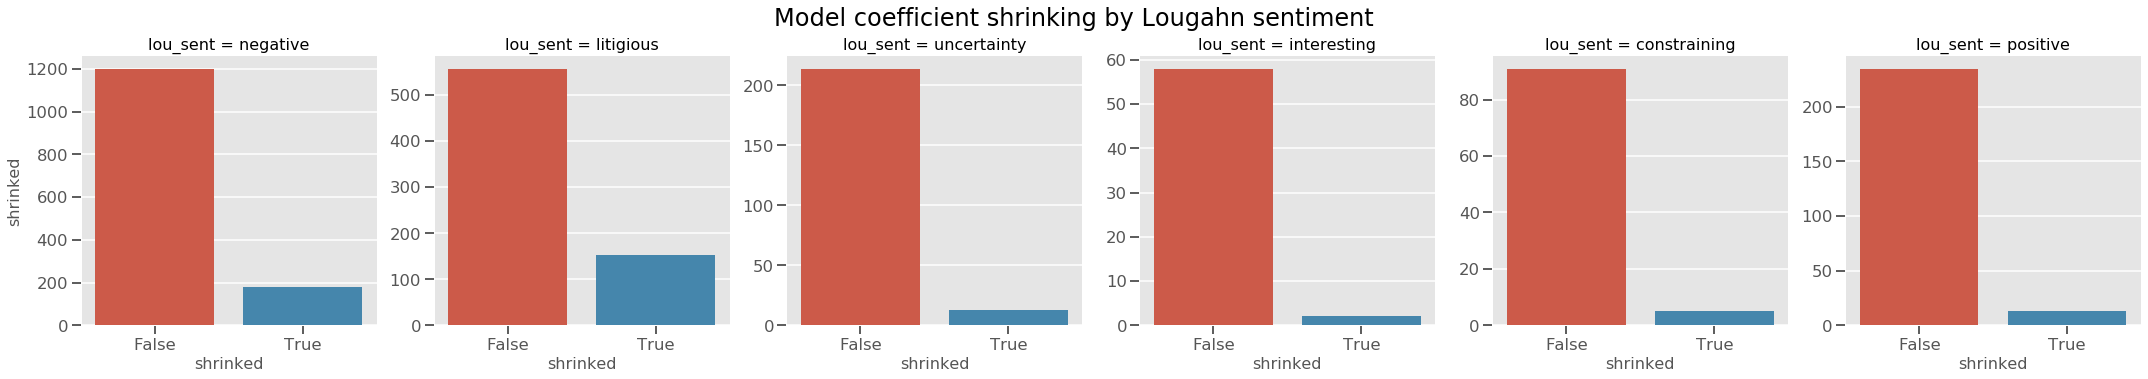

In [266]:
g = sns.catplot(x="shrinked", col="lou_sent", y='shrinked', kind='bar', estimator=np.size, data=champ_model_coefs_sent, sharey=False)

plt.suptitle('Model coefficient shrinking by Lougahn sentiment', y=1.05)
plt.show()

In [233]:
agg_champ_model_coefs_sent = champ_model_coefs_sent[champ_model_coefs_sent['coef']!=0].groupby('lou_sent')['coef'].describe()
agg_champ_model_coefs_sent

,count,mean,std,min,25%,50%,75%,max
lou_sent,,,,,,,,
constraining,91.0,0.021973,0.115977,-0.241743,-0.024139,0.004436,0.043914,0.727452
interesting,58.0,0.023061,0.090907,-0.115666,-0.022496,0.006441,0.036880,0.376413
litigious,557.0,0.000761,0.048411,-0.289773,-0.010651,0.000273,0.009250,0.277336
negative,1201.0,0.000123,0.059829,-0.552342,-0.014001,0.000036,0.009831,0.599872
positive,235.0,0.004430,0.082371,-0.380685,-0.027748,0.000742,0.033442,0.359222
uncertainty,214.0,0.005843,0.081887,-0.361316,-0.016365,0.000954,0.018951,0.386491


In [235]:
agg_sign_champ_model_coefs_sent = champ_model_coefs_sent[champ_model_coefs_sent['coef']!=0].groupby(['lou_sent', 'coef_positive'])['coef_abs'].describe()
agg_sign_champ_model_coefs_sent

count      mean       std           min       25%  \
lou_sent     coef_positive                                                      
constraining False           39.0  0.051568  0.056777  2.843917e-04  0.013372   
             True            52.0  0.077130  0.118730  4.743658e-04  0.012277   
interesting  False           24.0  0.042577  0.034801  1.785883e-03  0.010111   
             True            34.0  0.069393  0.089918  2.030645e-03  0.012301   
litigious    False          269.0  0.026037  0.037957  4.961113e-06  0.003228   
             True           288.0  0.025790  0.043509  5.500318e-05  0.002124   
negative     False          600.0  0.029352  0.046556  9.153563e-05  0.004729   
             True           601.0  0.029548  0.057089  3.600698e-05  0.003428   
positive     False          115.0  0.048682  0.063709  7.906578e-05  0.010281   
             True           120.0  0.055329  0.064150  2.660755e-04  0.011062   
uncertainty  False          103.0  0.040207  0.056351  3.050218e-07  0.005103   
             True           111.0  0.048574  0.078814  1.208672e-04  0.004059   

                                 50%       75%       max  
lou_sent     coef_positive                                
constraining False          0.029241  0.072491  0.241743  
             True           0.037413  0.085683  0.727452  
interesting  False          0.035588  0.064670  0.115666  
             True           0.031209  0.081369  0.376413  
litigious    False          0.011808  0.029665  0.289773  
             True           0.008847  0.023706  0.277336  
negative     False          0.014059  0.033480  0.552342  
             True           0.009831  0.028566  0.599872  
positive     False          0.028788  0.055227  0.380685  
             True           0.032256  0.070437  0.359222  
uncertainty  False          0.019896  0.055385  0.361316  
             True           0.016778  0.048541  0.386491

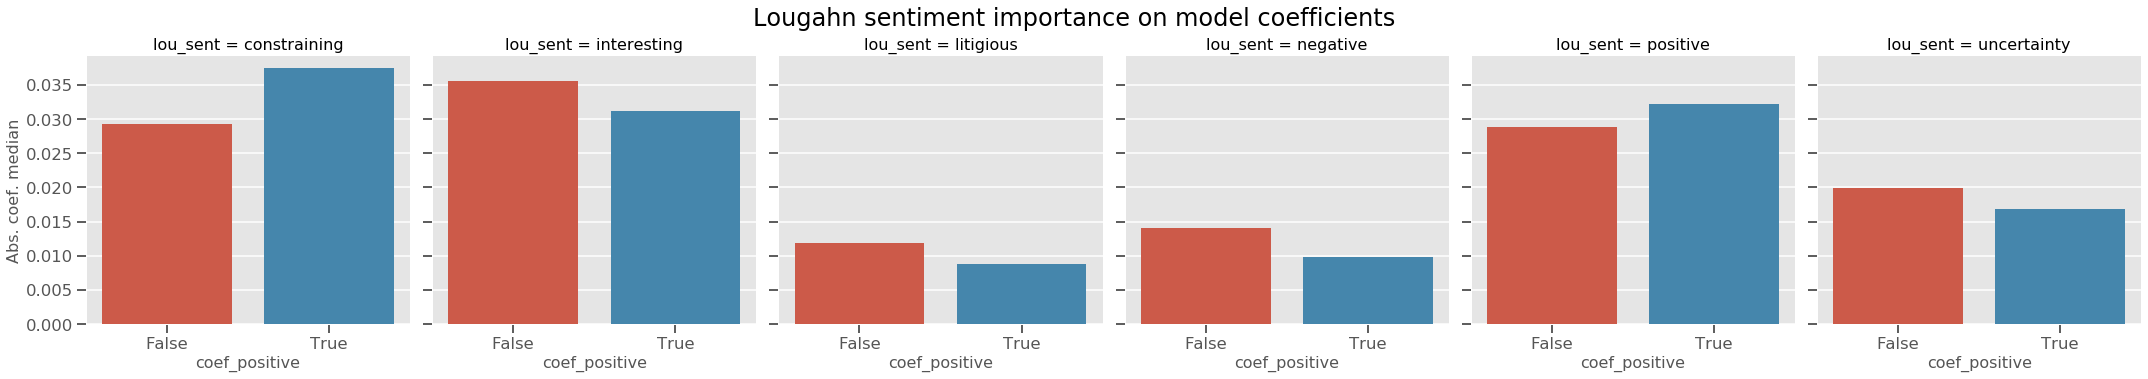

In [246]:
agg_sign_champ_model_coefs_sent_viz = agg_sign_champ_model_coefs_sent.reset_index().rename(columns={'50%': 'Abs. coef. median'})
g = sns.catplot(x="coef_positive", col="lou_sent", y='Abs. coef. median', kind='bar', data=agg_sign_champ_model_coefs_sent_viz)

plt.suptitle('Lougahn sentiment importance on model coefficients', y=1.05)
plt.show()

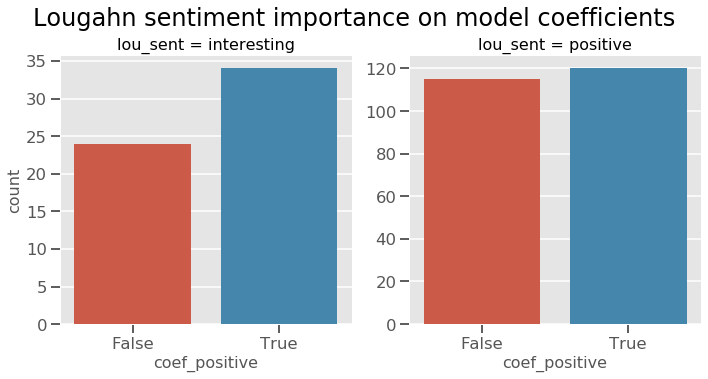

In [251]:

agg_sign_champ_model_coefs_sent_viz_subset = agg_sign_champ_model_coefs_sent_viz.loc[agg_sign_champ_model_coefs_sent_viz['lou_sent'].isin(['positive','interesting'])]

g = sns.catplot(x="coef_positive", col="lou_sent", y='count', kind='bar', data=agg_sign_champ_model_coefs_sent_viz_subset, sharey=False)

plt.suptitle('Lougahn sentiment importance on model coefficients', y=1.05)
plt.show()

Model limitations:

* There are only roughly 3 times more rows can columns, making it difficult to fit the model; denser representations are desirable to build a ml-sentiment alpha factor, however, this approach will be tested
* On constraining and interesing, median coefficientes are missmatched. That's it, con constraining, a higher absolute coefficient median is expected on negative coefs (False or red column), while on Interesting, it is expected on True-Blue. Those two sentiments are the ones with smaller vocabularies
* Other sentiments terms are properly assigned, nevertheless, there are no clear insights or differences from negative to positive medians.
* Approximatelly, a 15% of terms have been shrinked to zero.

## Assessment in test

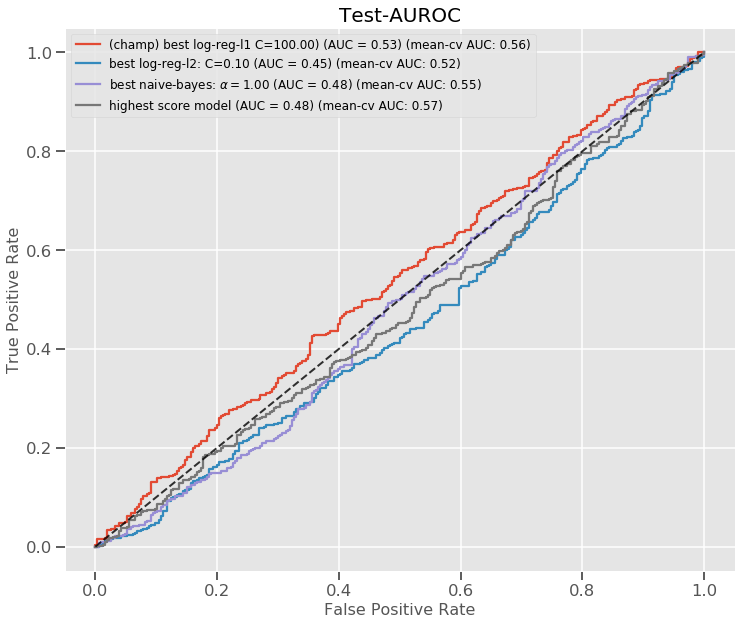

In [267]:
fig, ax = plt.subplots(1,1, figsize=(12, 10))

for i, row in enumerate(auc_plot_data):
    model, model_name, model_cv_score = row
    metrics.plot_roc_curve(model, X_test, y_test_c, ax=ax, name=model_name)
    #ax.text(1,0.15-i*0.05, f'{model_name}={model_score:0.2f}', va='bottom', ha='right')
    
handles, labels = ax.get_legend_handles_labels() 
labels = [f'{lab} (mean-cv AUC: {mean_cv_auc:0.2f})' for lab, mean_cv_auc in zip(labels, mean_cv_auc_lst)]
plt.legend(labels=labels)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Chance', alpha=.8)
plt.title("Test-AUROC")

plt.show()

In [145]:
grid_cv_sum.groupby('classifier')['mean_test_roc_auc'].apply(lambda x: np.sort(x)[-1])

classifier
logreg_l1    0.573025
logreg_l2    0.559222
nb           0.549794
Name: mean_test_roc_auc, dtype: float64

In [146]:
grid_cv_sum.sort_values(by=['classifier', 'rank_test_roc_auc']).groupby('classifier').first()

,classifier__alpha,classifier__C,classifier_params,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,idx
classifier,,,,,,,,,,,
logreg_l1,NaN,1.0,1.0,0.698532,0.543162,0.585216,0.590697,0.573025,0.021235,1,6
logreg_l2,NaN,1.0,1.0,0.689727,0.537954,0.560915,0.578796,0.559222,0.016717,2,11
nb,1.0,NaN,1.0,0.695178,0.534383,0.545943,0.569055,0.549794,0.014414,4,2


# Champion Model Predictions 

In [141]:
p_train = pd.Series(index=X_train.index, data=champ_mod.predict_proba(X_train)[:,1], name='sentiment_score')
p_test = pd.Series(index=X_test.index, data=champ_mod.predict_proba(X_test)[:,1], name='sentiment_score')

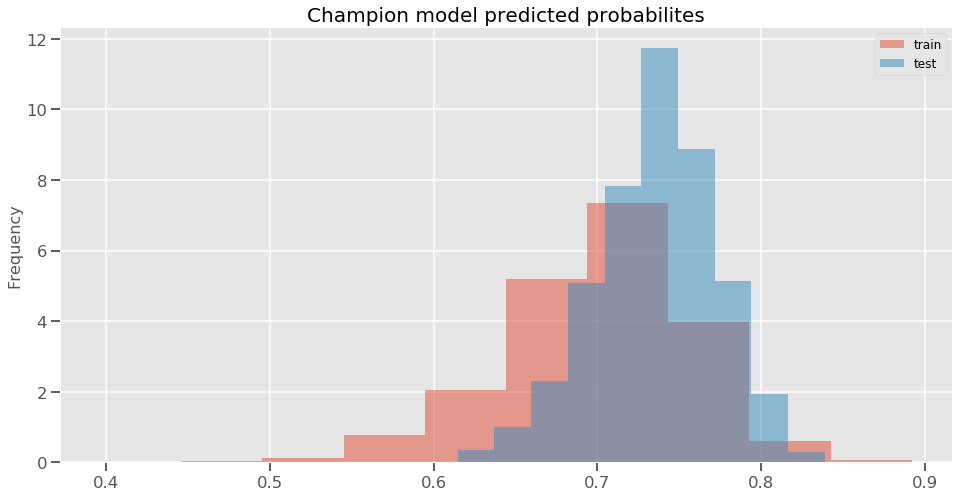

In [142]:
ax = p_train.plot.hist(density=True, alpha=0.5, label='train')
p_test.plot.hist(density=True, alpha=0.5, label='test', ax=ax)
plt.title("Champion model predicted probabilites")
plt.legend()
plt.show()

## From predictions to alpha factor

In [143]:
preds = pd.concat([p_train, p_test], axis=0).reset_index().merge(sector_to_asset, how='left', on='ticker').set_index(['date', 'ticker']).sort_index()
preds['sector_code'] = preds['sector_code'].fillna(-1)
preds['sector'] = preds['sector'].fillna("No sector")

In [144]:
sent_alphas = bow_sent.compute_sentiment_alpha_factor(sent_scores=preds, date_col='date', sector_col='sector_code', score_col='sentiment_score').\
    to_frame()
sent_alphas['split'] = splits
sent_alphas['date_filling'] = date_filling

sent_alphas = sent_alphas.sort_index()

pd.concat([pricing.head(2), pricing.tail(2)], axis=0)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,...,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-06,57.014,10.822,59.209,42.399,NaN,31.088,19.926,41.270,32.27,30.936,26.230,34.990,70.301,41.26,20.703,26.659,10.986,29.308,23.236,50.648,46.749,20.247,32.972,22.599,48.45,...,35.023,28.571,22.424,26.328,73.779,28.636,14.060,44.446,NaN,15.490,15.583,25.603,85.930,85.815,17.834,19.045,25.095,59.697,33.386,25.945,NaN,30.184,49.601,23.427,NaN
2011-01-07,57.495,10.976,60.790,42.702,NaN,31.150,20.009,41.338,32.04,30.756,26.445,35.070,70.026,40.76,20.703,26.555,10.986,29.371,23.145,51.440,47.314,20.088,32.596,22.458,48.69,...,34.814,28.589,22.594,25.796,73.468,28.479,14.283,44.545,NaN,15.346,16.011,25.509,88.972,87.296,17.993,19.010,24.954,60.023,33.251,25.583,NaN,30.560,49.592,23.182,NaN
2016-01-04,130.838,39.933,151.537,100.621,52.526,97.613,40.544,96.984,91.97,51.310,33.183,77.587,267.230,60.31,39.633,53.390,8.493,106.357,27.897,300.779,57.212,36.450,74.077,37.451,52.31,...,79.032,56.158,47.153,49.176,139.143,49.421,22.642,57.521,37.972,16.153,27.113,66.912,65.687,89.186,32.915,36.226,43.194,70.617,58.018,26.056,34.923,49.300,99.714,25.983,46.398
2016-01-05,131.369,39.552,150.502,98.100,52.307,99.041,40.534,97.489,92.34,50.933,33.553,77.776,269.531,60.39,40.103,53.829,8.611,107.837,27.859,302.012,57.410,37.378,75.313,37.553,52.02,...,76.958,55.916,47.659,49.157,136.146,49.610,22.720,58.887,37.947,16.089,27.177,67.441,66.929,89.761,33.247,36.302,43.836,71.218,59.201,26.005,34.913,49.177,101.790,25.701,47.124


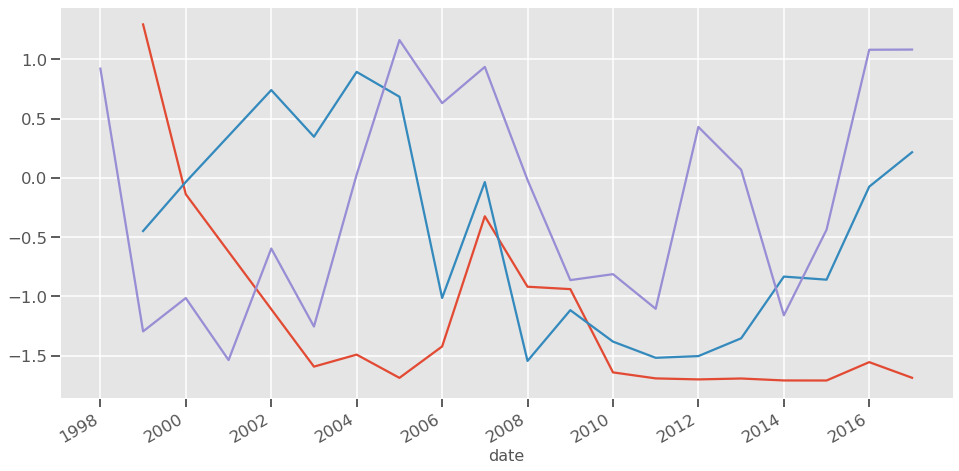

In [147]:
example = sent_alphas['sentiment_score']
ax = example.xs(key='amzn', level='ticker').plot()
example.xs(key='aapl', level='ticker').plot(ax=ax)
example.xs(key='msft', level='ticker').plot(ax=ax)
plt.show()

# Prediction Horizon Analysis

## Target: 20d

In [157]:
nbc_20d = MultinomialNB()

nbc_20d_cv1 = GridSearchCV(nbc_20d, {'alpha': alpha_grid}, scoring=['accuracy', 'roc_auc'],
                        n_jobs=-1, refit='roc_auc',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_20d_bin))
res_nbc_20d_cv1 = nbc_20d_cv1.fit(X_train_st, y_train_20d_bin)

In [158]:
logreg_20d = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='liblinear', penalty='l1', max_iter=500)

logreg_20d_cv1 = GridSearchCV(logreg_20d, {'C': c_grid}, scoring=['accuracy', 'roc_auc'],
                        n_jobs=-1, refit='roc_auc',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_20d_bin))
res_logreg_20d_cv1 = logreg_20d_cv1.fit(X_train_st, y_train_20d_bin)

In [159]:
pd.DataFrame(res_nbc_20d_cv1.cv_results_).filter(regex='(params|auc|mean_test_accuracy)')

,params,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,{'alpha': 0.01},0.559072,0.537943,0.483647,0.531236,0.517609,0.024170,4
1,{'alpha': 0.1},0.559072,0.538601,0.485147,0.531194,0.518314,0.023647,3
2,{'alpha': 1.0},0.574895,0.539340,0.487903,0.535423,0.520889,0.023379,2
3,{'alpha': 10.0},0.574895,0.539094,0.504154,0.543548,0.528932,0.017615,1


In [160]:
pd.DataFrame(res_logreg_20d_cv1.cv_results_).filter(regex='(params|auc|mean_test_accuracy)')

,params,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,{'C': 0.01},0.425105,0.500000,0.500000,0.500000,0.500000,0.000000,2
1,{'C': 0.1},0.574895,0.496960,0.484478,0.500145,0.493861,0.006761,3
2,{'C': 1.0},0.554852,0.531883,0.520648,0.520416,0.524316,0.005352,1
3,{'C': 10.0},0.507384,0.476807,0.500912,0.470754,0.482824,0.013026,4
4,{'C': 100.0},0.488397,0.472780,0.491388,0.475936,0.480035,0.008131,5


## Target: 5d

In [161]:
nbc_5d = MultinomialNB()

nbc_5d_cv1 = GridSearchCV(nbc_5d, {'alpha': alpha_grid}, scoring=['accuracy', 'roc_auc'],
                        n_jobs=-1, refit='roc_auc',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_5d_bin))
res_nbc_5d_cv1 = nbc_5d_cv1.fit(X_train_st, y_train_5d_bin)

In [163]:
logreg_5d = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='liblinear', penalty='l1', max_iter=500)

logreg_5d_cv1 = GridSearchCV(logreg_5d, {'C': c_grid}, scoring=['accuracy', 'roc_auc'],
                        n_jobs=-1, refit='roc_auc',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_5d_bin))
res_logreg_5d_cv1 = logreg_5d_cv1.fit(X_train_st, y_train_5d_bin)

In [164]:
pd.DataFrame(res_nbc_5d_cv1.cv_results_).filter(regex='(params|auc|mean_test_accuracy)')

,params,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,{'alpha': 0.01},0.559072,0.537943,0.483647,0.531236,0.517609,0.024170,4
1,{'alpha': 0.1},0.559072,0.538601,0.485147,0.531194,0.518314,0.023647,3
2,{'alpha': 1.0},0.574895,0.539340,0.487903,0.535423,0.520889,0.023379,2
3,{'alpha': 10.0},0.574895,0.539094,0.504154,0.543548,0.528932,0.017615,1


In [165]:
pd.DataFrame(res_logreg_5d_cv1.cv_results_).filter(regex='(params|auc|mean_test_accuracy)')

,params,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,{'C': 0.01},0.425105,0.500000,0.500000,0.500000,0.500000,0.000000,2
1,{'C': 0.1},0.574895,0.496960,0.484478,0.500145,0.493861,0.006761,3
2,{'C': 1.0},0.554852,0.531883,0.520648,0.520416,0.524316,0.005352,1
3,{'C': 10.0},0.507384,0.476807,0.500912,0.470754,0.482824,0.013026,4
4,{'C': 100.0},0.488397,0.472780,0.491388,0.475936,0.480035,0.008131,5


# Write Data

In [150]:
if FLG_OUTPUT:
    sent_alphas.to_csv(OUTPATH + OUTFILE1)